In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import scipy.spatial
import pandas as pd
import sys
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
# import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
# sys.path.insert(0, '../utils/') 
sys.path.insert(0, '../dataset_paper_repo_utils/') 
print(sys.path)
# from readProfiles import *
from pred_models import *
from readProfiles import *
from saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

# from utils import networksEvol, tsne, readProfiles
# import umap

['../dataset_paper_repo_utils/', '/sise/home/alonshp/AnomalyDetectionScreeningLocal/2.MoA prediction', '/sise/home/alonshp/AnomalyDetectionScreeningLocal/2.MoA prediction', '/home/alonshp/CellProfiling-research/code', '/home/alonshp/.conda/envs/tf-env/lib/python38.zip', '/home/alonshp/.conda/envs/tf-env/lib/python3.8', '/home/alonshp/.conda/envs/tf-env/lib/python3.8/lib-dynload', '', '/home/alonshp/.conda/envs/tf-env/lib/python3.8/site-packages']


In [5]:
pd.__version__

'1.4.2'

# Load raw measurements 

## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - RGCCA

### Paths

In [6]:
import os
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
results_dir='../results/'

fileName='RepCorrDF'
### dirs on gpu cluster
# rawProf_dir='/storage/data/marziehhaghighi/Rosetta/raw-profiles/'
# procProf_dir='/home/marziehhaghighi/workspace_rosetta/workspace/'

### dirs on ec2
# rawProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/raw-profiles/'
rawProf_dir='/sise/assafzar-group/assafzar/genesAndMorph'
# procProf_dir='./'
procProf_dir='/sise/assafzar-group/assafzar/genesAndMorph'
res_dir = f'{procProf_dir}/results'
# procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# s3://imaging-platform/projects/2018_04_20_Rosetta/workspace/preprocessed_data
# aws s3 sync preprocessed_data s3://cellpainting-datasets/Rosetta-GE-CP/preprocessed_data --profile jumpcpuser

filename='../../results/RepCor/'+fileName+'.xlsx'
os.makedirs(procProf_dir,exist_ok=True)

### Read GE and CP profiles 

In [7]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='CDRP-bio'


################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
# highRepOverlapEnabled=0
# 'highRepUnion','highRepOverlap',''
filter_perts='highRepUnion'
repCorrFilePath=f'{res_dir}/RepCorrDF.xlsx'

filter_repCorr_params=[filter_perts,repCorrFilePath]

################################################
pertColName='PERT'
if filter_perts:
    f='filt'
else:
    f=''

mergProf_treatLevel,cp_features,l1k_features = \
read_paired_treatment_level_profiles(procProf_dir,dataset,profileType,filter_repCorr_params,1)

moa_col='Metadata_MoA'

##################################
if dataset=='LINCS':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()    
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]
    
elif dataset=='CDRP-bio':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa'].str.lower()
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]

# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
# mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

# if profileLevel=='replicate':
#     l1k=mergProf_repLevel[[pertColName]+l1k_features]
#     cp=mergProf_repLevel[[pertColName]+cp_features]
# elif profileLevel=='treatment':
l1k=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+l1k_features]
cp=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+cp_features]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
    l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values)           


# if dataset=='LINCS':
merged_scaled=pd.concat([cp_scaled, l1k_scaled], axis=1)
merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]    
merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]
# elif dataset=='CDRP-bio':
#     l1k_scaled[moa_col]=cp_scaled[moa_col] # for CDRP
#     merged_scaled=pd.merge(cp_scaled, l1k_scaled, how='inner',on=['PERT',moa_col]); # for CDRP


#################### keep MOAs with more than "nSamplesMOA" compounds in their class

nSamplesMOA=4

nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
print('If we filter to MoAs which have more than',nSamplesMOA+1,' compounds in their category, ',\
      len(listOfSelectedMoAs),' out of ',nSamplesforEachMOAclass.shape[0] ,' MoAs remain.')



multi_label_MoAs=[l for l in listOfSelectedMoAs if '|' in l]
print('There are ',len(listOfSelectedMoAs),'MoA categories, which out of them ',len(multi_label_MoAs),\
      ' have multi labels and is removed')

listOfSelectedMoAs=[ele for ele in listOfSelectedMoAs if ele not in multi_label_MoAs]

le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

# IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].unique().tolist()

# rgcca_factors_cp=pd.read_csv("../JDR/results_CP_GE_cdrpbio/factors_rgcca_cp.txt",sep="\t").reset_index(drop=True)
# rgcca_factors_ge=pd.read_csv("../JDR/results_CP_GE_cdrpbio/factors_rgcca_ge.txt",sep="\t").reset_index(drop=True).add_suffix('_ge')
# rgcca_concat=pd.concat([rgcca_factors_cp,rgcca_factors_ge],axis=1)

filteredMOAs=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True)



filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

# nSamplesMOA=0 and union
print("There are ", filteredMOAs.shape[0],"samples across different doses of ",filteredMOAs['Compounds'].unique().shape[0] ,\
      "compounds", ", for ",filteredMOAs["Metadata_MoA"].unique().shape[0], "MoAs")

../dataset_paper_repo_utils/readProfiles.py:51: DtypeWarning: Columns (981,982,983) have mixed types. Specify dtype option on import or set low_memory=False.
  l1k_data_repLevel=pd.read_csv(dataDir+'/L1000/replicate_level_l1k.csv.gz')


CDRP-bio: Replicate Level Shapes (nSamples x nFeatures): cp:  21122 , 601 ,  l1k:  6929 , 977
l1k n of rep:  2.0
cp n of rep:  8.0
CP: from  2239  to  312
l1k: from  1535  to  448
CP and l1k high rep union:  629
Treatment Level Shapes (nSamples x nFeatures+metadata): (630, 604) (572, 978) Merged Profiles Shape: (573, 1581)
If we filter to MoAs which have more than 5  compounds in their category,  16  out of  268  MoAs remain.
There are  16 MoA categories, which out of them  0  have multi labels and is removed
There are  123 samples across different doses of  123 compounds , for  16 MoAs


In [8]:
data4eval=[[cp_scaled[cp_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),cp_features],\
           [l1k_scaled[l1k_scaled[moa_col].isin(listOfSelectedMoAs)].reset_index(drop=True),l1k_features],\
           [filteredMOAs,cp_features+l1k_features]]
           # [rgcca_factors_cp,rgcca_factors_cp.columns.tolist()],\
           # [rgcca_factors_ge,rgcca_factors_ge.columns.tolist()],\
           # [rgcca_concat,rgcca_concat.columns.tolist()]]


In [9]:
filteredMOAs.groupby(['Metadata_MoA']).size()

Metadata_MoA
acetylcholine receptor antagonist           6
adrenergic receptor agonist                12
adrenergic receptor antagonist              9
atpase inhibitor                            8
bacterial cell wall synthesis inhibitor     5
calcium channel blocker                     7
cdk inhibitor                               5
dopamine receptor agonist                   6
dopamine receptor antagonist               17
egfr inhibitor                              5
glucocorticoid receptor agonist            10
glutamate receptor antagonist               5
protein synthesis inhibitor                 6
serotonin receptor agonist                  9
serotonin receptor antagonist               7
tubulin polymerization inhibitor            6
dtype: int64

In [10]:
filteredMOAs.groupby(['Metadata_MoA','Compounds']).size().max()

1

In [11]:
nSamplesforEachMOAclass

,Metadata_MoA,size
0,dopamine receptor antagonist,17
1,adrenergic receptor agonist,12
2,glucocorticoid receptor agonist,10
3,serotonin receptor agonist,9
4,adrenergic receptor antagonist,8
...,...,...
263,egfr inhibitor|src inhibitor,1
264,egfr inhibitor|tyrosine kinase inhibitor,1
265,endothelin receptor antagonist,1
266,estrogen receptor antagonist|dna directed dna ...,1


### Number of Classes with more than one label

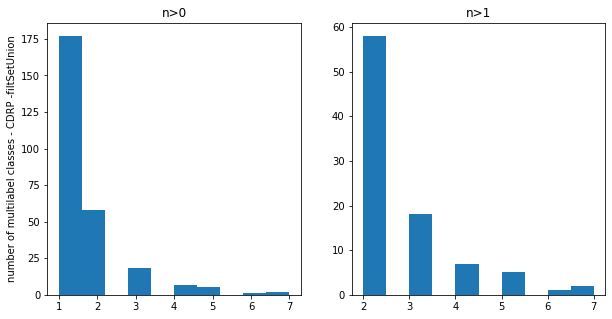

In [12]:
unq=mergProf_treatLevel['Metadata_MoA'].unique().tolist()
unq.remove(np.nan)
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');
axes[0].set_ylabel('number of multilabel classes - CDRP -filtSetUnion');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel classes');

#### Number of Samples with more than one label

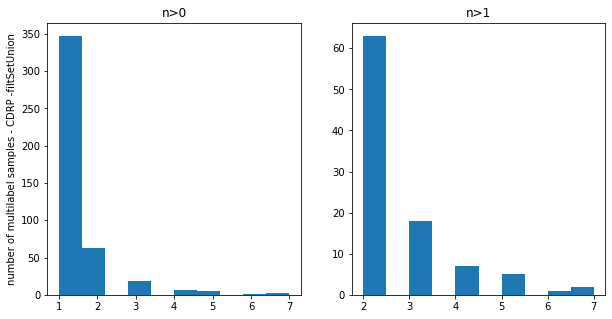

In [13]:
unq=mergProf_treatLevel['Metadata_MoA'].tolist()
unq=[u for u in unq if str(u) != 'nan']
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');axes[0].set_ylabel('number of multilabel samples - CDRP -filtSetUnion');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel samples');

In [14]:


# mergProf_treatLevel.columns[mergProf_treatLevel.columns.str.contains('moa')]
# # list(set(mergProf_treatLevel.columns.tolist())-set(cp_features))
unq

['dopamine receptor agonist',
 'chk inhibitor',
 'farnesyltransferase inhibitors',
 'cytotoxic lipid peroxidation product',
 'protein synthesis inhibitor',
 'adenosine kinase inhibitor|nucleoside transporter inhibitor',
 'gaba receptor modulator',
 'microtubule formation inhibitor|tubulin inhibitor|tubulin polymerisation inhibitor',
 'estrogen receptor agonist',
 'tubulin inhibitor|microtubule stabilizing agent|microtubule stimulant|p glycoprotein inhibitor|taxane',
 'gaba receptor antagonist|tp53 activator',
 'protein synthesis inhibitor',
 'calcium channel blocker',
 'atpase inhibitor',
 'dopamine receptor agonist',
 'p38 mapk inhibitor',
 'atpase inhibitor',
 'protein phosphatase inhibitor',
 'hsp90 inhibitor',
 'protein phosphatase inhibitor',
 'atpase inhibitor',
 'ppar receptor agonist',
 'jak inhibitor|lipocortin synthesis stimulant|stat inhibitor',
 'plant alkaloid',
 'adrenergic receptor agonist',
 'dopamine receptor agonist',
 'atr kinase inhibitor',
 'adrenergic receptor ant

In [15]:
mergProf_treatLevel.head()

,PERT,Cells_Texture_SumAverage_DNA_3_0,Cells_AreaShape_Zernike_4_0,Cytoplasm_Intensity_MaxIntensity_ER,Cytoplasm_RadialDistribution_FracAtD_DNA_3of4,Cells_AreaShape_FormFactor,Cytoplasm_Correlation_K_AGP_DNA,Nuclei_Intensity_MinIntensity_ER,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Intensity_IntegratedIntensity_ER,...,204608_at,211071_s_at,203341_at,202801_at,206414_s_at,204978_at,205379_at,203897_at,Metadata_MoA,Compounds
0,BRD-A04231641-003-01-3_10.0,-1.029318,0.294822,0.123059,0.930591,-0.065299,-0.365340,0.389100,0.514078,0.955562,...,0.935852,1.046744,0.123402,-1.203804,0.230033,0.288086,-0.242703,-0.017547,NaN,BRD-A04231641
1,BRD-A04438777-001-01-4_10.0,-0.976134,0.406901,-0.591754,-0.149186,-0.522802,0.070942,-0.230740,-0.267465,0.093021,...,-0.935083,-1.422195,0.009955,0.292542,0.656249,-1.136107,2.305811,-0.403211,dopamine receptor agonist,BRD-A04438777
2,BRD-A06352508-001-02-9_10.0,-0.382209,0.551690,-2.507010,-1.828389,-0.235492,-0.547430,-0.763105,0.202946,-0.742752,...,1.110025,-1.362606,-1.084117,-0.572485,-0.108951,0.980438,0.390327,-0.137197,chk inhibitor,BRD-A06352508
3,BRD-A07952294-001-02-3_8.93,-1.131735,-0.222901,-0.752674,0.297249,-0.334545,0.111587,-0.135877,0.653539,0.021546,...,-0.536336,-0.020809,1.221776,0.677735,0.149212,-0.034550,1.145593,0.288290,farnesyltransferase inhibitors,BRD-A07952294
4,BRD-A15914070-001-01-5_10.0,-1.414629,0.350964,-0.284117,0.062865,-0.909425,0.852865,0.455526,-0.308946,0.760246,...,-0.469221,0.511872,-1.322366,0.181557,0.651313,0.757776,1.027886,1.360957,cytotoxic lipid peroxidation product,BRD-A15914070


In [16]:
# mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]
mergProf_treatLevel[['Metadata_moa']]

,Metadata_moa
0,NaN
1,dopamine receptor agonist
2,CHK inhibitor
3,farnesyltransferase inhibitors
4,cytotoxic lipid peroxidation product
...,...
568,T-type calcium channel blocker
569,cannabinoid receptor agonist|potassium channel...
570,PLK inhibitor
571,PDGFR tyrosine kinase receptor inhibitor|Bcr-A...


In [17]:
# mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

In [18]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

In [19]:
# cp['Compounds'],cp['PERT']
pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])

,Metadata_MoA,size_x,size_y
0,dopamine receptor antagonist,17,17
1,adrenergic receptor agonist,12,12
2,glucocorticoid receptor agonist,10,10
3,serotonin receptor agonist,9,9
4,adrenergic receptor antagonist,8,9
...,...,...,...
263,egfr inhibitor|src inhibitor,1,1
264,egfr inhibitor|tyrosine kinase inhibitor,1,1
265,endothelin receptor antagonist,1,1
266,estrogen receptor antagonist|dna directed dna ...,1,1


In [20]:
# pd.concat([nSamplesforEachMOAclass,nSamplesforEachMOAclass2])
nSamplesforEachMOAclass

,Metadata_MoA,size
0,dopamine receptor antagonist,17
1,adrenergic receptor agonist,12
2,glucocorticoid receptor agonist,10
3,serotonin receptor agonist,9
4,adrenergic receptor antagonist,8
...,...,...
263,egfr inhibitor|src inhibitor,1
264,egfr inhibitor|tyrosine kinase inhibitor,1
265,endothelin receptor antagonist,1
266,estrogen receptor antagonist|dna directed dna ...,1


/tmp/ipykernel_118236/2483407028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass_['h']='n-compounds'
/tmp/ipykernel_118236/2483407028.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass2_['h']='n-samples'


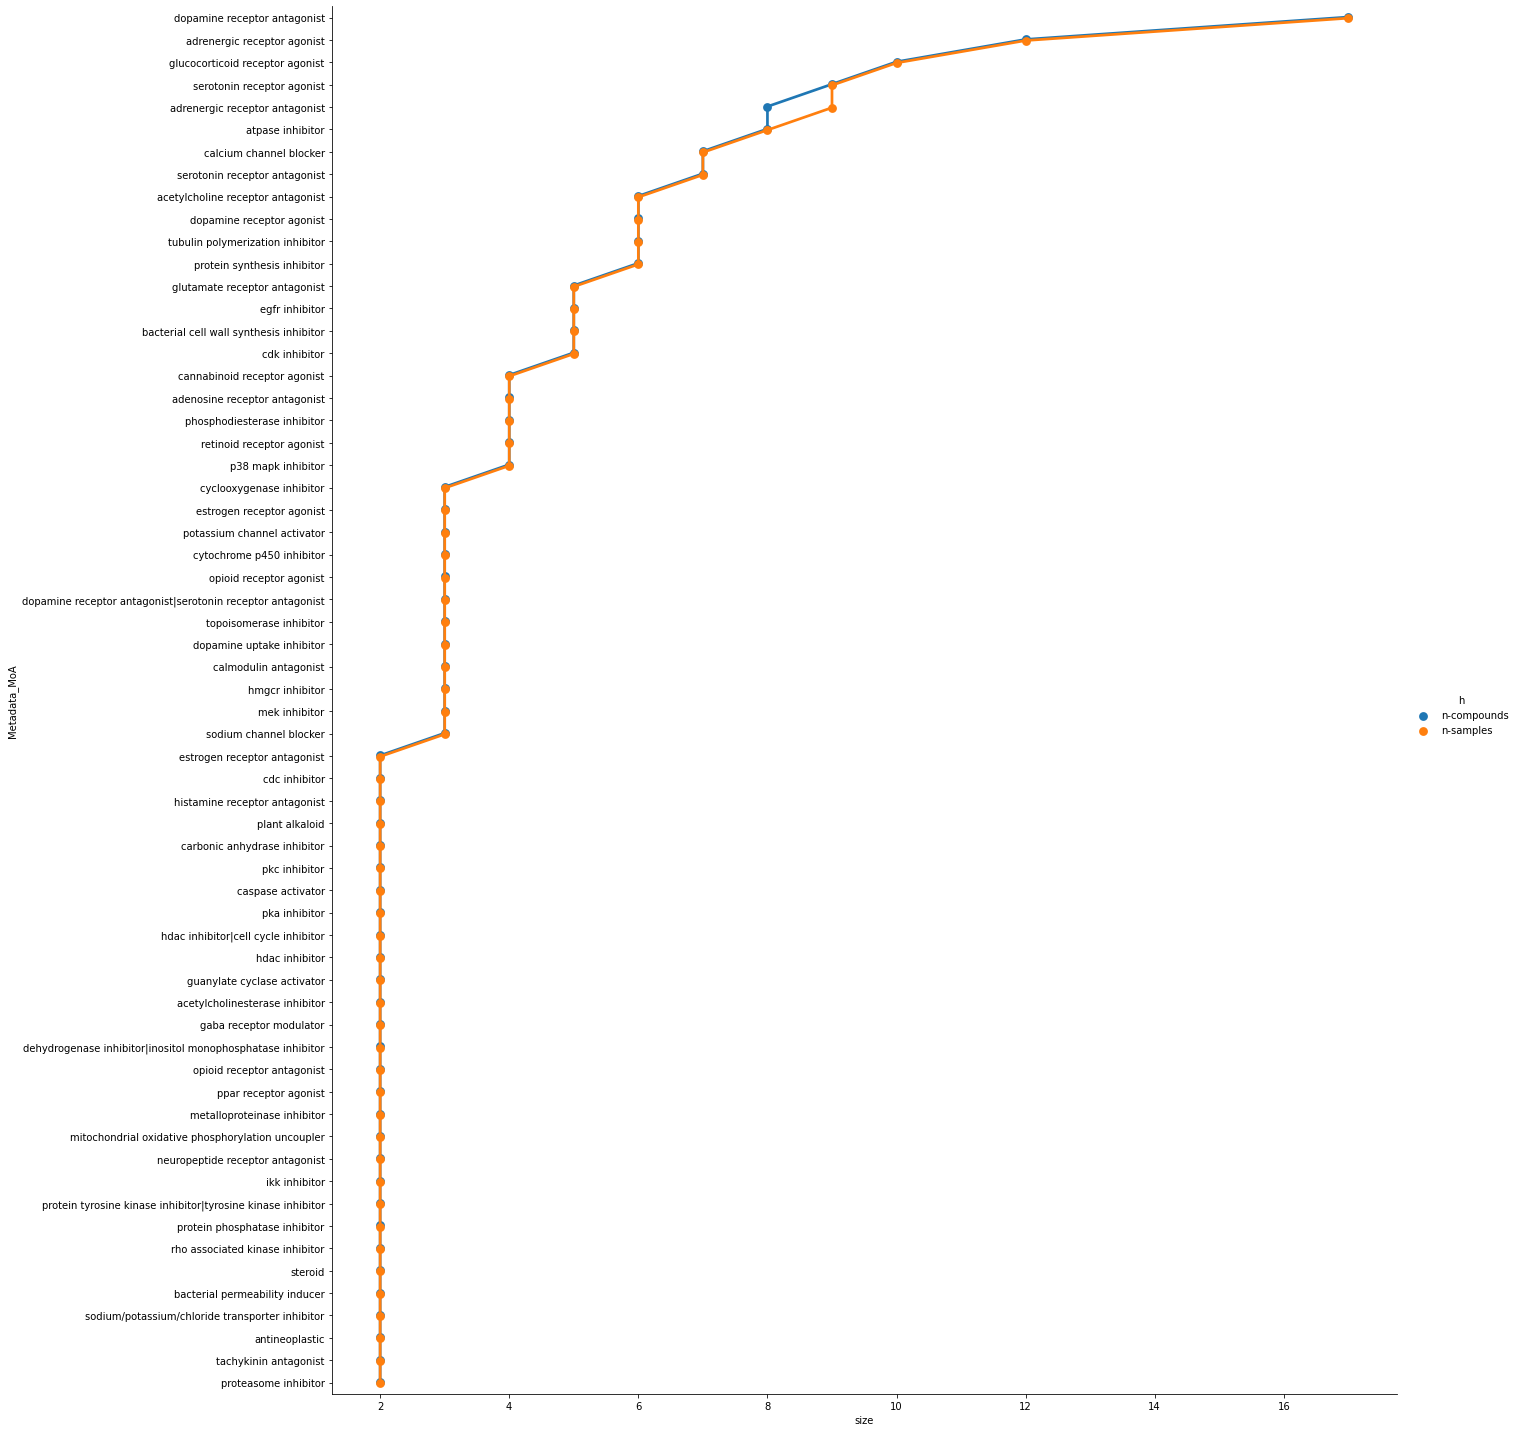

In [21]:
# plt.figure()
# fig, axes = plt.subplots(figsize=(20,5))
# nSamplesforEachMOAclass3=pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])
nSamplesforEachMOAclass_=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]
nSamplesforEachMOAclass2_=nSamplesforEachMOAclass2[nSamplesforEachMOAclass2[moa_col].isin(nSamplesforEachMOAclass_[moa_col].tolist())]
nSamplesforEachMOAclass_['h']='n-compounds'
nSamplesforEachMOAclass2_['h']='n-samples'

nSamplesforEachMOAclass3=pd.concat([nSamplesforEachMOAclass_,nSamplesforEachMOAclass2_])

sns.catplot(x="size",y=moa_col, data=nSamplesforEachMOAclass3[nSamplesforEachMOAclass3['size']>1],\
            orient="h", height=20, aspect=1,hue='h',
                kind="point", dodge=True, cut=0, bw=.2)
# fig.tight_layout()

In [23]:
# repp_df
# nSamplesforEachMOAclass2[meta_col]

In [24]:
# mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).sort_values(by='nrep')
moa_col='moa'

In [25]:
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

67


In [26]:
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

67


In [28]:
# listOfSelectedMoAs
# filteredMOAs['Metadata_moa_num']#=le.transform(filteredMOAs[moa_col].tolist())
# filteredMOAs[moa_col].tolist()

In [29]:
nSamplesforEachMOAclass

,Metadata_moa,size
0,dopamine receptor antagonist,11
1,glucocorticoid receptor agonist,9
2,ATPase inhibitor,8
3,Adrenergic receptor agonist,8
4,Dopamine receptor antagonist,6
...,...,...
284,Ras GTPase inhibitor,1
285,Serotonin receptor antagonist,1
286,Sodium/potassium/chloride transporter inhibitor,1
287,Sulfonylurea,1


In [ ]:
# IDs4filteredMOAs

In [30]:
# nSamplesforEachMOAclass
# IDs4filteredMOAs
# pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])
filteredMOAs.loc[test_index,'Compounds'].unique()[0]

NameError: name 'test_index' is not defined

### MoA prediction using each dataset and early and late fusion of datasets

In [ ]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())
# cls_model='mlp'#'mlp';#'lr'
for cls_model in ['mlp']:
# for cls_model in ['mlp']:
    moa_pred_res=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion',\
                                        'RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion','Late Fusion','Metadata_moa_num'])

    # n_of_random_sel=20
    # n_of_random_sel=50
    # n_folds=5
    # acc_array_fullSet2_cdrp=np.zeros((n_of_random_sel,4));
    # acc_array_filtSet2_cdrp=np.zeros((n_of_random_sel,4));
    # for i in range(n_of_random_sel):

    #     split_obj=GroupKFold(n_splits=k)
    # #     split_obj = LeaveOneGroupOut()    
    #     # Perform k-fold cross validation
    #     scores = cross_val_score(clf, X, y, groups=group_labels,cv=split_obj,n_jobs=n_j)

    # kf = KFold(n_splits=n_folds,random_state=1,shuffle=True)
    # gkf=GroupKFold(n_splits=n_folds)


    parameter_space_MLP = {
        'hidden_layer_sizes': [(100,),(200),(400)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001,0.05],
    }

    # parameter_space_MLP = {
    #     'hidden_layer_sizes': [(10,30,10),(20,)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['sgd', 'adam'],
    #     'alpha': [0.0001, 0.05],
    #     'learning_rate': ['constant','adaptive'],
    # }


    # parameter_space_logistic={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    parameter_space_logistic={"C":[1,10,1000]}





    logo = LeaveOneGroupOut()

    leG = preprocessing.LabelEncoder()
    group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

    i=0
    # for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
    for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
        print('rand ',i)
        i+=1

    #     data_train = filteredMOAs.loc[train_index,domXfeats].values;
        labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)

    #     data_test = filteredMOAs.loc[test_index,domXfeats].values;
        labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    

        class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)
        sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)
        probs=[]
        for n,dt_modality,col in zip([0,1,2,3,4,5],data4eval,['CP','GE','Early Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']):

            data_m=dt_modality[0]   

            dt_train=data_m.loc[train_index,dt_modality[1]].values;
            dt_test=data_m.loc[test_index,dt_modality[1]].values; 
        #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    #         model_tr = GaussianNB()
    #         model_tr = ComplementNB()

    #         model_tr = RandomForestClassifier(n_estimators=10)

    #         model_logistic = LogisticRegression(multi_class='multinomial',max_iter=1000,class_weight="balanced")        
    #         model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=2)

            if cls_model=='lr':
                model_logistic = LogisticRegression(multi_class='multinomial',class_weight="balanced")        
                model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=2)

            elif cls_model=='mlp':
                
#                 model_tr = MLPClassifier(random_state=10,max_iter=600,alpha=0.0001,activation='tanh',hidden_layer_sizes=(200,))
                model_MLP = MLPClassifier(random_state=20,max_iter=600)
                model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=2)

            dt_train_balanced,labels_train_balanced = sm1.fit_resample(dt_train,labels_train)

            model_tr.fit(dt_train_balanced,labels_train_balanced)        

#             print(model_tr.best_params_)
    #         accc=model_tr.score(dt_test,labels_test)
    #         print(model_tr.predict(dt_test))
    #         accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
            moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)
    #         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
            probs.append(model_tr.predict_proba(dt_test))

    #     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
        labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
        labels_lateFusion
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Metadata_moa_num']=\
        labels_test
    #     f1_score(labels_test,labels_lateFusion, average='weighted')*100
    #     accuracy_score(labels_test,labels_lateFusion)*100

    moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
    print(moa_pred_res.mean())


    filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
    saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-'+cls_model+'-ht-5')

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

#### StratifiedGroupKFold

In [ ]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,StratifiedGroupKFold
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler
# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

# cls_model='lr'#'mlp';#'lr'
for cls_model in ['mlp','lr']:
    moa_pred_res=pd.DataFrame(index=filteredMOAs.index,columns=['CP','GE','Early Fusion',\
                                        'RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion','Late Fusion','Metadata_moa_num'])


    moa_pred_res['PERT']=filteredMOAs['PERT']
    moa_pred_res['Compounds']=filteredMOAs['Compounds']

    # parameter_space_MLP = {
    #     'hidden_layer_sizes': [(50,),(100,),(200)],
    #     'activation': ['tanh'],
    #     'alpha': [0.0001],
    # }
    parameter_space_MLP = {
        'hidden_layer_sizes': [(100,),(200),(400)],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001,0.05],
        'learning_rate': ['constant','adaptive'],
    }

    # parameter_space_MLP = {
    #     'hidden_layer_sizes': [(10,30,10),(20,)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['sgd', 'adam'],
    #     'alpha': [0.0001, 0.05],
    #     'learning_rate': ['constant','adaptive'],
    # }


    # parameter_space_logistic={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
    parameter_space_logistic={"C":[1,10,1000]}


    from sklearn.model_selection import GridSearchCV



    # logo = LeaveOneGroupOut()

    sgkf = StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=1)

    leG = preprocessing.LabelEncoder()
    group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

    i=0
    # for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
    for train_index, test_index in sgkf.split(filteredMOAs,filteredMOAs['Metadata_moa_num'].values, groups=group_labels):
        print('rand ',i)
        i+=1

    #     data_train = filteredMOAs.loc[train_index,domXfeats].values;
        labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)

    #     data_test = filteredMOAs.loc[test_index,domXfeats].values;
        labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
    #     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    

    #     class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

    #     overSampleMinorityFirstClassTo=np.max([labels_train.count(i) for i in set(labels_train)])

    #     ratios = {l: overSampleMinorityFirstClassTo for l in set(labels_train) \
    #       if labels_train.count(l)<overSampleMinorityFirstClassTo}
    #     sm1=RandomOverSampler(ratio=ratios)
        moa_pred_res.loc[test_index,'Fold']=i

        sm1=RandomOverSampler(sampling_strategy='not majority',random_state=5)

        probs=[]

        for n,dt_modality,col in zip([0,1,2,3,4,5],data4eval,['CP','GE','Early Fusion','RGCCA_CP',\
                    'RGCCA_GE','RGCCA_EarlyFusion','Fold']):


            data_m=dt_modality[0]

            dt_train=data_m.loc[train_index,dt_modality[1]].values;
            dt_test=data_m.loc[test_index,dt_modality[1]].values; 
        #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    #         model_tr = GaussianNB()
    #         model_tr = ComplementNB()

    #         model_tr = RandomForestClassifier(n_estimators=10)

            if cls_model=='lr':
    #             model_tr = LogisticRegression(multi_class='multinomial',class_weight="balanced")        

                model_logistic = LogisticRegression(multi_class='multinomial',class_weight="balanced",n_jobs=4)        
                model_tr = GridSearchCV(model_logistic, parameter_space_logistic, n_jobs=4, cv=3)

            elif cls_model=='mlp':
    #             model_MLP = MLPClassifier(random_state=5,max_iter=100,alpha=0.0001,activation='tanh')
                model_MLP = MLPClassifier(random_state=5,max_iter=600)
                model_tr = GridSearchCV(model_MLP, parameter_space_MLP, n_jobs=4, cv=3)

            dt_train_balanced,labels_train_balanced = sm1.fit_resample(dt_train,labels_train)

            model_tr.fit(dt_train_balanced,labels_train_balanced)
    #         print(model_tr.best_params_)
    #         accc=model_tr.score(dt_test,labels_test)
    #         print(model_tr.predict(dt_test))
    #         accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
            moa_pred_res.loc[test_index,col]=model_tr.predict(dt_test)
    #         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
            probs.append(model_tr.predict_proba(dt_test))

    #     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
        labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
        moa_pred_res.loc[test_index,'Late Fusion']=\
        labels_lateFusion
        moa_pred_res.loc[test_index,'Metadata_moa_num']=\
        labels_test
    #     f1_score(labels_test,labels_lateFusion, average='weighted')*100
    #     accuracy_score(labels_test,labels_lateFusion)*100

    moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
    print(moa_pred_res.mean())


    filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
    saveAsNewSheetToExistingFile(filename,moa_pred_res,'fC-'+dataset+'-'+profTypeAbbrev+'-'+f+'-preds-'+cls_model+'-ht-sgkf-10f')


In [ ]:
# len(indexes)
indexes[1].shape

## Visualize the results

In [ ]:
filename=results_dir+'/MoAprediction/pred_moa_CDRP.xlsx'
saved_scores_cdrpbio=pd.read_excel(filename, sheet_name=None)
saved_scores_cdrpbio.keys()


In [ ]:
from sklearn.metrics import f1_score
#########################################################
res_df_cdrpbio=pd.DataFrame(columns=['Modality','Model'])
DS='CDRP-bio'
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht-sgkf-1']
# scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-mlp-ht']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-mlp-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

        f1=f1_score(scor_vals,scores_mlp_f.Metadata_moa_num.values, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['MLP'],'F1-score':[f1*100]})
        res_df_cdrpbio=res_df_cdrpbio.append(temp_df)
    
    
scores_mlp=saved_scores_cdrpbio['fC-'+DS+'-nvs-filt-preds-lr-ht-sgkf-1']
# mofa_scores_2add=saved_scores['mofa-100fac'+DS+'-nvs-filt-preds-lr-ht-2']
# scores_mlp['mofa']=mofa_scores_2add['mofa']

folds=scores_mlp['Fold'].unique().tolist()
for f in folds:
    scores_mlp_f=scores_mlp[scores_mlp['Fold']==f];
    # for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_CP','RGCCA_GE','RGCCA_EarlyFusion']:
    for dd in ['CP', 'GE', 'Early Fusion', 'Late Fusion','RGCCA_EarlyFusion']:
        scor_vals=scores_mlp_f[dd].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
        f1=f1_score(scores_mlp_f.Metadata_moa_num.values,scor_vals, average='macro')
        temp_df = pd.DataFrame(data={'Modality': [dd], 'Model': ['Logistic R'],'F1-score':[f1*100]})
        res_df_cdrpbio=res_df_cdrpbio.append(temp_df)


In [ ]:
# res_df_cdrpbio
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
# sns.set_style("whitegrid")
fig,axes=plt.subplots(1,2,figsize=(10,5),sharey=True)
# sns.barplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
sns.boxplot(x="Model", y="F1-score", hue="Modality", data=res_df_cdrpbio,ax=axes[0])#,**kwargs)
# plt.legend(loc='top', borderaxespad=0)
# plt.legend(bbox_to_anchor=(0.27, 1), loc='upper left', borderaxespad=0)
axes[0].legend([],[], frameon=False)
plt.tight_layout()
axes[0].set_ylim(0,50)
axes[0].set_title('CDRP-bio')
n_classes=16;
axes[0].axhline(y=(1/n_classes),linestyle='--',color='r',linewidth=2);

In [ ]:
# scores_mlp[['Late Fusion','RGCCA_EarlyFusion']]

In [ ]:
# report_clss

In [ ]:
# report_clss
from sklearn.metrics import classification_report
scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-1']
scor_vals=scores_mlp['Late Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

In [ ]:
# report_clss_cp.loc[report_clss3.index]['f1-score']
%matplotlib inline
import matplotlib.style as style
style.use('seaborn-colorblind')
sns.set_style("whitegrid")
sns.set_context("paper",font_scale = 1.5, rc={"font.size":4,"axes.titlesize":14,"axes.labelsize":15})
report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'RGCCA_EarlyFusion'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4[report_clss4["RGCCA_EarlyFusion"]>0].plot.bar(rot=90,figsize=(5,6.5),fontsize=15)
plt.title('MoA class specific F1-scores\n CDRP-bio')
ax.set_ylim([0,1])
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

if 1:
    source_data_add='../Figs_Source_Data.xlsx'
    saveAsNewSheetToExistingFile(source_data_add,report_clss4,'fig4c_1')

    # fig.tight_layout()
    plt.savefig('fig4c_1.pdf',papertype='letter',dpi=500)

In [ ]:
report_clss4[report_clss4["RGCCA_EarlyFusion"]==0].shape

In [ ]:
report_clss4[report_clss4["RGCCA_EarlyFusion"]>0].index

In [ ]:
lincs_moa_top=['mTOR inhibitor', 'glucocorticoid receptor agonist', 'HSP inhibitor',
       'proteasome inhibitor', 'MEK inhibitor', 'HDAC inhibitor',
       'tubulin polymerization inhibitor', 'PLK inhibitor', 'EGFR inhibitor',
       'retinoid receptor agonist', 'CDK inhibitor', 'topoisomerase inhibitor',
       'p38 MAPK inhibitor', 'AKT inhibitor', 'serotonin receptor antagonist',
       'gamma secretase inhibitor', 'HMGCR inhibitor', 'PI3K inhibitor',
       'rho associated kinase inhibitor', 'cyclooxygenase inhibitor',
       'protein synthesis inhibitor', 'histamine receptor antagonist',
       'sterol demethylase inhibitor', 'PKC inhibitor',
       'dopamine receptor antagonist', 'adrenergic receptor antagonist',
       'vitamin D receptor agonist', 'acetylcholine receptor antagonist',
       'progesterone receptor agonist', 'dopamine receptor agonist',
       'benzodiazepine receptor agonist', 'phosphodiesterase inhibitor',
       'calcium channel blocker', 'adrenergic receptor agonist']

cdrp_moa_top=['tubulin polymerization inhibitor', 'atpase inhibitor',
       'glucocorticoid receptor agonist', 'cdk inhibitor',
       'adrenergic receptor agonist', 'dopamine receptor antagonist',
       'protein synthesis inhibitor', 'serotonin receptor antagonist',
       'calcium channel blocker', 'dopamine receptor agonist',
       'serotonin receptor agonist', 'adrenergic receptor antagonist']

# top_cdrp_lincs_overlap=list(set(lincs_moa_top) & set(cdrp_moa_top))
top_cdrp_lincs_overlap=['glucocorticoid receptor agonist',
 'tubulin polymerization inhibitor',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'dopamine receptor agonist',
 'serotonin receptor antagonist',
 'adrenergic receptor antagonist',
 'adrenergic receptor agonist',
 'calcium channel blocker']

# ax = report_clss4[:15].plot.bar(rot=90,figsize=(7,7))
ax =report_clss4.loc[top_cdrp_lincs_overlap].plot.bar(rot=90,figsize=(6,6))
ax.set_ylim([0,1])
plt.title('MoA class specific F1-scores')
plt.tight_layout()

In [ ]:
# report_clss4.loc[top_cdrp_lincs_overlap]
top_cdrp_lincs_overlap

In [ ]:
report_clss2['support']=report_clss2['support'].astype(int)
report_clss2['n_samples']=report_clss2['support']

In [ ]:

# plt.figure(figsize=(5,5))
# import matplotlib.style as style
# style.use('seaborn-colorblind')
# sns.scatterplot(data=report_clss2, x="n_samples", y="f1-score", hue="MoA",legend=True)
# plt.tight_layout()# p
# plt.savefig('moa_class_scatter.eps')

In [ ]:
from sklearn.metrics import classification_report
# scores_mlp=saved_scores['fC-CDRP-bio-nvs-filt-preds-mlp-ht']
# scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filt-preds-mlp-ht']
scores_mlp=saved_scores_cdrpbio['fC-CDRP-bio-nvs-filt-preds-mlp-ht-sgkf-1']
scor_vals=scores_mlp['Late Fusion'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_cp=scores_mlp['CP'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    
scor_vals_ge=scores_mlp['GE'].apply(lambda x: int(eval(x)[0]) if type(x)==str else x)    

report_clss=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals.values,output_dict=True)).transpose()
report_clss_cp=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_cp.values,output_dict=True)).transpose()
report_clss_ge=pd.DataFrame(classification_report(scores_mlp.Metadata_moa_num.values,scor_vals_ge.values,output_dict=True)).transpose()

# report_clss[list(range(13))]
# n_classes=14
n_classes=16
report_clss['MoA']=''
# report_clss
report_clss.loc[0:n_classes,'MoA']=le.inverse_transform(list(range(n_classes)))
report_clss2=report_clss[0:n_classes]

report_clss3=report_clss2.sort_values(by='f1-score',ascending=False)
report_clss3['f1-score-cp']=report_clss_cp.loc[report_clss3.index]['f1-score'].values
report_clss3['f1-score-ge']=report_clss_ge.loc[report_clss3.index]['f1-score'].values
report_clss4=report_clss3[['f1-score-cp','f1-score-ge','f1-score']]
report_clss4=report_clss4.rename(columns={'f1-score-cp':'CP','f1-score-ge':'GE','f1-score':'Late Fusion of CP and GE'})
report_clss4.index=report_clss3['MoA']
ax = report_clss4.plot.bar(rot=90,figsize=(8,6))
plt.title('MoA class specific F1-scores')
plt.tight_layout()
# plt.savefig('moa_class_spacific_bar.eps')

In [ ]:
described_data=DataFuseResults_filt2.groupby([moa_col]).describe()